In [22]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import librosa
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D


# ===== CONFIG =====
AUDIO_DIR = "C:/Users/saisa/Downloads/audio_dataset/audio"
LABELS_CSV = "C:/Users/saisa/Downloads/audio_dataset/labels.csv"
SAMPLE_RATE = 16000
DURATION_SEC = 4.0
N_MELS = 64
HOP_LENGTH = 256

# ===== MEL-SPECTROGRAM EXTRACTION =====
def extract_melspec(wav_path, n_mels=N_MELS, hop_length=HOP_LENGTH):
    y, _ = librosa.load(wav_path, sr=SAMPLE_RATE, mono=True)
    y = librosa.util.fix_length(y, size=int(SAMPLE_RATE * DURATION_SEC))
    S = librosa.feature.melspectrogram(y=y, sr=SAMPLE_RATE, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return np.mean(S_db, axis=1)  # (n_mels,)

# ===== LOAD LABELS.CSV =====
df = pd.read_csv(LABELS_CSV)
df['filename'] = df['filename'].str.strip()
df['out_of_tune'] = df['out_of_tune'].astype(str).str.strip()

# ===== SELECT FIRST 50 .WAV FILES THAT EXIST IN LABELS =====
all_files = sorted([f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')])
first_50_files = all_files[:50]

# Filter the DataFrame for those 50 files
df_filtered = df[df['filename'].isin(first_50_files)].reset_index(drop=True)

# Rebuild filepaths and labels
filepaths = [os.path.join(AUDIO_DIR, fname) for fname in df_filtered['filename']]
labels = df_filtered['out_of_tune'].values

# ===== DEBUG PRINTS (Optional) =====
print(f"✅ Total files selected: {len(filepaths)}")
print(f"✅ Labels matched: {len(labels)}")


✅ Total files selected: 50
✅ Labels matched: 50


In [23]:
# ===== ENCODE LABELS =====
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)
joblib.dump(label_encoder, 'label_encoder.joblib')

# ===== EXTRACT MEL FEATURES =====
X = np.stack([extract_melspec(fp) for fp in filepaths])  # Shape: (N, 64)
X = np.expand_dims(X, axis=-1)  # Shape: (N, 64, 1) → for CNN input
y = one_hot_labels

In [24]:
# ===== FILTER CLASSES WITH ≥5 SAMPLES =====
class_indices = np.argmax(y, axis=1)
(unique, counts) = np.unique(class_indices, return_counts=True)
valid_classes = unique[counts >= 5]
valid_indices = [i for i, cls in enumerate(class_indices) if cls in valid_classes]

X = X[valid_indices]
y = y[valid_indices]
class_indices = np.argmax(y, axis=1)

if len(X) == 0:
    raise ValueError("No valid samples left after filtering. Try reducing the min sample threshold.")

# ===== TRAIN TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=class_indices, test_size=0.2, random_state=42)

In [25]:
from tensorflow.keras import backend as K
K.clear_session()

# ===== 1D CNN MODEL FOR AUDIO FEATURES =====
input_layer = Input(shape=(64, 1))

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(y.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,068 (238.55 KB)

 Trainable params: 61,068 (238.55 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# ===== CALLBACKS =====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# ===== EVALUATION =====
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ===== SAVE MODEL =====
model.save("fused_out_of_tune_model.h5")

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 11.0258 - val_accuracy: 0.0000e+00 - val_loss: 7.5393 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0526 - loss: 8.4418 - val_accuracy: 0.0000e+00 - val_loss: 6.8818 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.0526 - loss: 8.1995 - val_accuracy: 0.0000e+00 - val_loss: 6.2866 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0000e+00 - loss: 8.8225 - val_accuracy: 0.0000e+00 - val_loss: 5.7324 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0526 - loss: 9.4580 - val_accuracy: 0.0000e+00 - val_loss: 5.2029 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.0526 - loss: 8.5109 - val_accuracy: 0.0000e+00 - val_loss: 4.7319 - learning_rate: 1.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/s

c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
          10       0.20      1.00      0.33         1

    accuracy                           0.20         5
   macro avg       0.07      0.33      0.11         5
weighted avg       0.04      0.20      0.07         5


Confusion Matrix:
 [[0 0 2]
 [0 0 2]
 [0 0 1]]


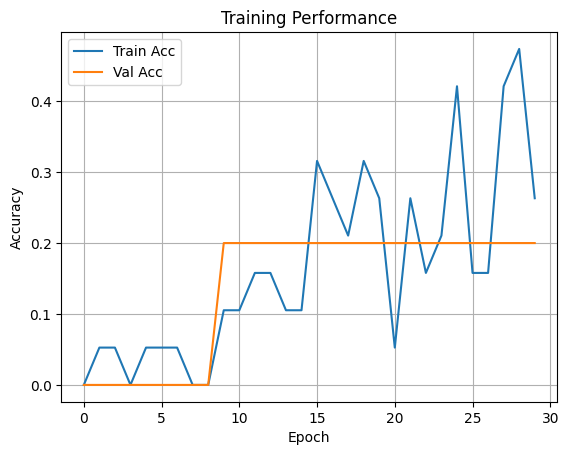

In [27]:
# ===== OPTIONAL: PLOT TRAINING =====
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Performance')
plt.grid()
plt.show()

In [28]:
# ===== VGGish + 1D CNN Transfer Learning using hub.KerasLayer =====

import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Clear session
K.clear_session()

# Load VGGish model using KerasLayer (TF1.x module)
vggish_layer = hub.KerasLayer("https://tfhub.dev/google/vggish/1", input_shape=[], dtype=tf.float32)

# Wrap it into a functional model for embedding extraction
vggish_input = tf.keras.Input(shape=(None,), dtype=tf.float32)
vggish_output = vggish_layer(vggish_input)
vggish_model = tf.keras.Model(inputs=vggish_input, outputs=vggish_output)

# Define embedding extractor function
def extract_vggish_embedding(wav_path, sample_rate=16000):
    y, _ = librosa.load(wav_path, sr=sample_rate, mono=True)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    y = tf.expand_dims(y, 0)  # shape: (1, None)
    embedding = vggish_model(y)
    return embedding.numpy()[0]  # shape: (128,)

# Generate embeddings for all audio files
print("Extracting VGGish embeddings...")
X_vggish = np.stack([extract_vggish_embedding(fp) for fp in filepaths])  # shape: (N, 128)
X_vggish = np.expand_dims(X_vggish, axis=-1)  # shape: (N, 128, 1)

# Reuse pre-encoded labels
y_vggish = y.copy()

# Filter classes with at least 5 samples
class_indices = np.argmax(y_vggish, axis=1)
(unique, counts) = np.unique(class_indices, return_counts=True)
valid_classes = unique[counts >= 5]
valid_indices = [i for i, cls in enumerate(class_indices) if cls in valid_classes]

X_vggish = X_vggish[valid_indices]
y_vggish = y_vggish[valid_indices]
class_indices = np.argmax(y_vggish, axis=1)

# Split the data
X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(
    X_vggish, y_vggish, stratify=class_indices, test_size=0.2, random_state=42
)

# ===== VGGish + 1D CNN CLASSIFIER =====

input_layer = Input(shape=(128, 1))

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Dropout(0.3)(x)
x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(y_vggish.shape[1], activation='softmax')(x)

vggish_model_final = Model(inputs=input_layer, outputs=output)
vggish_model_final.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

vggish_model_final.summary()

# ===== CALLBACKS =====
vggish_callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)
]

# ===== TRAIN THE MODEL =====
history_vggish = vggish_model_final.fit(
    X_train_vgg, y_train_vgg,
    validation_data=(X_test_vgg, y_test_vgg),
    epochs=40,
    batch_size=64,
    callbacks=vggish_callbacks
)

# ===== EVALUATE =====
y_pred_probs_vggish = vggish_model_final.predict(X_test_vgg)
y_pred_vggish = np.argmax(y_pred_probs_vggish, axis=1)
y_true_vggish = np.argmax(y_test_vgg, axis=1)

print("\nClassification Report (VGGish):\n", classification_report(y_true_vggish, y_pred_vggish))
print("\nConfusion Matrix (VGGish):\n", confusion_matrix(y_true_vggish, y_pred_vggish))

# ===== SAVE MODEL =====
vggish_model_final.save("vggish_cnn_out_of_tune_model.h5")

# ===== PLOT TRAINING CURVE =====
plt.figure(figsize=(10,5))
plt.plot(history_vggish.history['accuracy'], label='Train Acc (VGGish)')
plt.plot(history_vggish.history['val_accuracy'], label='Val Acc (VGGish)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('VGGish Transfer Learning Performance')
plt.grid()
plt.show()

TypeError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None, None), dtype=float32, sparse=False, name=keras_tensor>,) and kwargs: {} for signature: (waveform: TensorSpec(shape=(None,), dtype=tf.float32, name=None)).

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, None), dtype=float32, sparse=False, name=keras_tensor>
  • training=None

# MLP Model

In [29]:
# ===== MLP MODEL FOR AUDIO FEATURES =====

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization


In [30]:
# Reshape input for MLP: (N, 64, 1) → (N, 64)
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

# Clear previous session
K.clear_session()

mlp_model = Sequential()

In [31]:
# ===== INPUT LAYER =====
mlp_model.add(Input(shape=(64,)))

# ===== DEEP FULLY CONNECTED BLOCKS =====
mlp_model.add(Dense(1024, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.5))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.4))

mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.2))

# ===== OUTPUT LAYER =====
mlp_model.add(Dense(y.shape[1], activation='softmax'))

# ===== COMPILE =====
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 764,300 (2.92 MB)

 Trainable params: 760,716 (2.90 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [32]:
# ===== CALLBACKS =====
mlp_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)
]

# ===== TRAIN MLP MODEL =====
mlp_history = mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_test_mlp, y_test),
    epochs=30,
    batch_size=32,
    callbacks=mlp_callbacks
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0526 - loss: 3.4972 - val_accuracy: 0.0000e+00 - val_loss: 20.6144 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0526 - loss: 3.5980 - val_accuracy: 0.0000e+00 - val_loss: 18.8067 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0000e+00 - loss: 3.0769 - val_accuracy: 0.0000e+00 - val_loss: 17.3846 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.0000e+00 - loss: 3.4461 - val_accuracy: 0.0000e+00 - val_loss: 16.2305 - learning_rate: 1.0000e-04
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.1579 - loss: 2.9181 - val_accuracy: 0.0000e+00 - val_loss: 15.2540 - learning_rate: 1.0000e-04
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0000e+00 - loss: 2.9418 - val_accuracy: 0.0000e+00 - val_loss: 14.4168 - learning_rate: 1.0000e-04
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [33]:
# ===== EVALUATION =====
y_pred_probs_mlp = mlp_model.predict(X_test_mlp)
y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
y_true_mlp = np.argmax(y_test, axis=1)

print("\nMLP Classification Report:\n", classification_report(y_true_mlp, y_pred_mlp))
print("\nMLP Confusion Matrix:\n", confusion_matrix(y_true_mlp, y_pred_mlp))

# ===== SAVE MLP MODEL =====
mlp_model.save("mlp_out_of_tune_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       2.0
          10       0.00      0.00      0.00       1.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0


MLP Confusion Matrix:
 [[0 1 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 0 0]
 [0 0 1 0 0]]


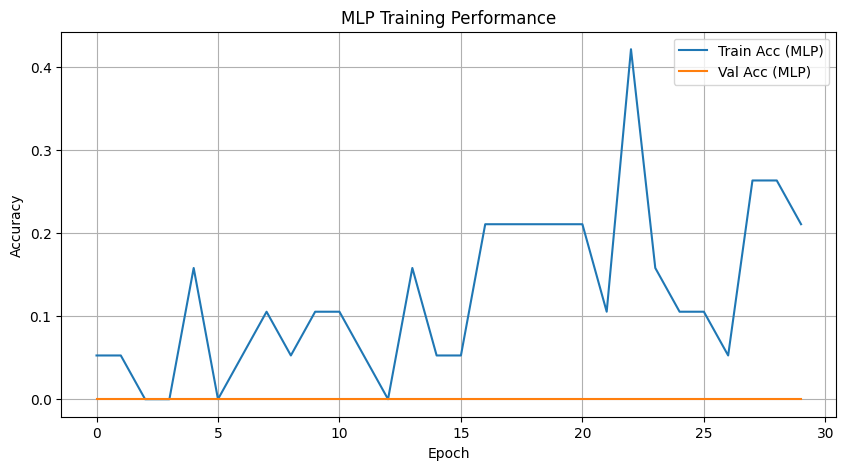

In [34]:
# ===== OPTIONAL: PLOT MLP TRAINING =====
plt.figure(figsize=(10,5))
plt.plot(mlp_history.history['accuracy'], label='Train Acc (MLP)')
plt.plot(mlp_history.history['val_accuracy'], label='Val Acc (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Training Performance')
plt.grid()
plt.show()


# Transfer Learning

In [80]:
import tensorflow_hub as hub
import tensorflow as tf
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [81]:
# ===== Load VGGish model from TensorFlow Hub =====
vggish = hub.KerasLayer(
    "https://tfhub.dev/google/vggish/1",
    input_shape=[SAMPLE_RATE * int(DURATION_SEC)],
    dtype=tf.float32,
    trainable=False,
    name="vggish"
)


In [82]:
# ===== Function to extract VGGish embeddings =====
def extract_vggish(path):
    y, _ = librosa.load(path, sr=SAMPLE_RATE, mono=True, duration=DURATION_SEC)
    if len(y) < SAMPLE_RATE * DURATION_SEC:
        y = np.pad(y, (0, SAMPLE_RATE * DURATION_SEC - len(y)))  # Pad if too short
    patches = vggish(y)  # Returns shape (T, 128)
    mean_emb = tf.reduce_mean(patches, axis=0)  # Mean-pool the time dimension
    return mean_emb.numpy().astype(np.float32)  # Force float32 dtype


In [83]:
# ===== Ensure valid_indices does not exceed the size of y =====
valid_indices = [i for i in valid_indices if i < len(y)]  # Filter invalid indices

# ===== Filter filepaths and labels based on valid indices =====
files_tl = [filepaths[i] for i in valid_indices]
X_vgg = np.stack([extract_vggish(fp) for fp in files_tl], axis=0)

# ===== Ensure y_vgg is properly filtered and one-hot encoded =====
y_vgg = y[valid_indices].astype(np.float32)
y_vgg = to_categorical(y_vgg, num_classes=12)  # Ensure one-hot encoding (shape: (None, 12))

# ===== Ensure the lengths match =====
if len(X_vgg) != len(y_vgg):
    raise ValueError(f"Mismatch between X_vgg ({len(X_vgg)}) and y_vgg ({len(y_vgg)})")

In [84]:
# ===== Train/test split =====
Xv_train, Xv_test, yv_train, yv_test = train_test_split(
    X_vgg, y_vgg,
    test_size=0.2,
    stratify=np.argmax(y_vgg, axis=1),  # Ensure stratified split by class
    random_state=42
)


In [85]:
# ===== 1D CNN with VGGISH =====
def make_cnn1d_vgg(input_dim, n_classes):
    inp = tf.keras.Input(shape=(input_dim, 1))
    x = Conv1D(64, 3, padding="same", activation="relu")(inp)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, padding="same", activation="relu")(x)
    x = MaxPooling1D(2)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation="softmax")(x)
    m = Model(inp, out, name="cnn1d_vggish")
    m.compile(Adam(1e-4), "categorical_crossentropy", ["accuracy"])
    return m

# ===== Reshape embeddings for Conv1D =====
Xv_train_c = Xv_train[..., np.newaxis]  # Reshape to (N,128,1)
Xv_test_c = Xv_test[..., np.newaxis]  # Shape matches Conv1D input

# ===== Build and train the model =====
cnn_tl = make_cnn1d_vgg(128, yv_train.shape[1])  # 128 is the input dimension, yv_train.shape[1] is number of classes
hist_cnn = cnn_tl.fit(
    Xv_train_c, yv_train,
    validation_data=(Xv_test_c, yv_test),
    epochs=20, batch_size=64,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=1)
    ]
)

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 12, 12), output.shape=(None, 12)

In [ ]:
#MLP on VGGish
def make_mlp_vgg(input_dim, n_classes):
    inp = tf.keras.Input(shape=(input_dim,))
    x = Dense(256, activation="relu")(inp)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation="softmax")(x)
    m = Model(inp, out, name="mlp_vggish")
    m.compile(Adam(1e-4), "categorical_crossentropy", ["accuracy"])
    return m

mlp_tl   = make_mlp_vgg(128, yv_tr.shape[1])  # input_dim=128 vector
hist_mlp = mlp_tl.fit(
    Xv_tr, yv_tr,
    validation_data=(Xv_te, yv_te),
    epochs=20, batch_size=64,
    callbacks=[ EarlyStopping("val_loss",5,True),
                ReduceLROnPlateau("val_loss",2,0.2,1) ]
)

In [ ]:
#Evaluate Both Transfer Learning Models
def report_tl(model, X, y, title):
    y_pred = np.argmax(model.predict(X), axis=1)
    y_true = np.argmax(y, axis=1)
    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.xticks(rotation=45); plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

report_tl(mlp_tl, Xv_test,      yv_test, "MLP + VGGish (TL)")
report_tl(cnn_tl, Xv_te_c,      yv_test, "1D-CNN + VGGish (TL)")

In [ ]:
#Plots
plt.figure(figsize=(10,4))
plt.plot(history.history['val_accuracy'],   'k--', label='CNN scratch')
plt.plot(mlp_history.history['val_accuracy'],'k:', label='MLP scratch')
plt.plot(hist_mlp_tl.history['val_accuracy'],'b-', label='MLP + VGGish')
plt.plot(hist_cnn_tl.history['val_accuracy'],'r-', label='CNN + VGGish')
plt.title("Val Accuracy: Scratch vs. Transfer-Learned")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

In [20]:
#VGGISH Backbone
import tensorflow_hub as hub
import tensorflow as tf

files_tl = [filepaths[i] for i in valid_indices]

waveforms = np.stack([
    librosa.util.fix_length(
        librosa.load(fp, sr=SAMPLE_RATE, mono=True, duration=DURATION_SEC)[0],
        size=int(SAMPLE_RATE * DURATION_SEC)
    )
    for fp in files_tl
], axis=0).astype(np.float32)

os.environ["TFHUB_CACHE_DIR"] = os.path.expanduser("~/my_project/tfhub_cache")
print("Loading VGGish from TF-Hub…")
vggish_layer = hub.KerasLayer(
    "https://tfhub.dev/google/vggish/1",
    dtype=tf.float32,
    trainable=False
)
inputs = tf.keras.Input(shape=(SAMPLE_RATE * int(DURATION_SEC),), dtype=tf.float32)
patches = vggish_layer(inputs)                 # (None, T, 128)
mean_embed = tf.reduce_mean(patches, axis=1)   # (None, 128)
embed_model = tf.keras.Model(inputs, mean_embed)

X_vgg = embed_model.predict(waveforms, batch_size=256, verbose=1)
y_vgg = y[valid_indices].astype(np.float32)

Loading VGGish from TF-Hub…



TypeError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

Binding inputs to tf.function failed due to `A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
`. Received args: (<KerasTensor shape=(None, 64000), dtype=float32, sparse=False, name=keras_tensor_79>,) and kwargs: {} for signature: (waveform: TensorSpec(shape=(None,), dtype=tf.float32, name=None)).

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 64000), dtype=float32, sparse=False, name=keras_tensor_79>
  • training=None